<a href="https://colab.research.google.com/github/876arham/Siamese/blob/master/Siamese_IVp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive')  #change dir





In [ ]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

def read_image(filename, byteorder='>'):
    
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                         dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                         count=int(width)*int(height),
                         offset=len(header)
                         ).reshape((int(height), int(width)))
size = 2
total_sample_size = 10000


def get_data(size, total_sample_size):
    #read the image
    image = read_image('arub/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    #image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2]) # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('arub/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('arub/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            #img1 = img1[::size, ::size]
            #img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('arub/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('arub/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            #img1 = img1[::size, ::size]
            #img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y
X, Y = get_data(size, total_sample_size)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X, Y, test_size=0.25,random_state=42)

(15000, 2, 1, 112, 92)

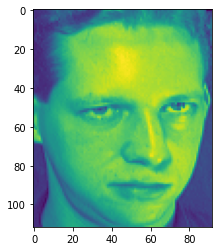

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt 
x_train
img2 = read_image('arub/s' + str(1) + '/' + str(10) + '.pgm', 'rw+')
plt.imshow(img2)
img2.shape
x_train.shape

In [ ]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [32,32,64]
    kernel_size = 2
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], (kernel_size, kernel_size),strides=(1,1), input_shape=input_shape,
                          padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))
    
    kernel_size = 3

    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], (kernel_size, kernel_size), strides=(1,1),padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first')) 
    seq.add(Dropout(.25))

     
    kernel_size = 3

     #convolutional layer 3
    seq.add(Convolution2D(nb_filter[2], (kernel_size, kernel_size),strides=(1,1), padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first')) 
    seq.add(Dropout(.25))

         
    kernel_size = 4

     #convolutional layer 4
    seq.add(Convolution2D(nb_filter[2], (kernel_size, kernel_size),strides=(1,1), padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first')) 
    seq.add(Dropout(.25))



    #flatten 
    seq.add(Flatten())
    seq.add(Dense(256, activation='relu'))
    seq.add(Dropout(0.1))
    
    seq.add(Dense(64, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq
  

In [ ]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [ ]:
epochs = 50
rms = RMSprop()

model = Model([img_a, img_b], distance)

In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

model.compile(loss=contrastive_loss, optimizer=rms)

In [ ]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1] 

model.fit([img_1, img_2], y_train, validation_split=.25, batch_size=128, verbose=2, epochs=epochs)
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

Epoch 1/50
88/88 - 8s - loss: 0.2551 - val_loss: 0.4509
Epoch 2/50
88/88 - 8s - loss: 0.1544 - val_loss: 0.2443
Epoch 3/50
88/88 - 8s - loss: 0.1263 - val_loss: 0.2966
Epoch 4/50
88/88 - 8s - loss: 0.0985 - val_loss: 0.2624
Epoch 5/50
88/88 - 8s - loss: 0.0803 - val_loss: 0.3054
Epoch 6/50
88/88 - 8s - loss: 0.0703 - val_loss: 0.2531
Epoch 7/50
88/88 - 8s - loss: 0.0599 - val_loss: 0.2117
Epoch 8/50
88/88 - 8s - loss: 0.0512 - val_loss: 0.1302
Epoch 9/50
88/88 - 8s - loss: 0.0439 - val_loss: 0.1530
Epoch 10/50
88/88 - 8s - loss: 0.0400 - val_loss: 0.0701
Epoch 11/50
88/88 - 8s - loss: 0.0362 - val_loss: 0.1393
Epoch 12/50
88/88 - 8s - loss: 0.0326 - val_loss: 0.0954
Epoch 13/50
88/88 - 8s - loss: 0.0296 - val_loss: 0.0984
Epoch 14/50
88/88 - 8s - loss: 0.0281 - val_loss: 0.0850
Epoch 15/50
88/88 - 8s - loss: 0.0253 - val_loss: 0.0964
Epoch 16/50
Epoch 17/50
88/88 - 8s - loss: 0.0212 - val_loss: 0.0568
Epoch 18/50
88/88 - 8s - loss: 0.0197 - val_loss: 0.0455
Epoch 19/50
88/88 - 8s - los

In [ ]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])
pred

array([[1.8073846 ],
       [0.00283556],
       [0.00848907],
       ...,
       [0.01073353],
       [1.9794743 ],
       [1.8637143 ]], dtype=float32)

In [ ]:
x_test[:,0].shape

(5000, 1, 112, 92)

In [ ]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.15].mean() 

In [ ]:
compute_accuracy(pred, y_test)


0.9948758376034686

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 


Saved model to disk


In [ ]:
#loaded_model.compile(loss=contrastive_loss, optimizer=rms)
#pred = loaded_model.predict([x_test[:, 0], x_test[:, 1]])

NameError: ignored

In [ ]:
compute_accuracy(pred, y_test)

0.9948758376034686

In [ ]:
pred

array([[1.8073846 ],
       [0.00283556],
       [0.00848907],
       ...,
       [0.01073353],
       [1.9794743 ],
       [1.8637143 ]], dtype=float32)

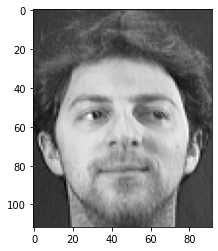

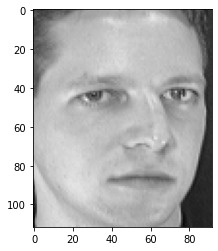

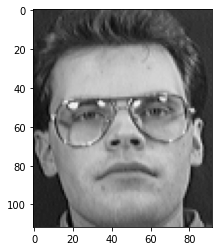

[[[[54. 51. 49. ... 58. 56. 57.]
   [54. 49. 52. ... 58. 60. 56.]
   [51. 51. 55. ... 62. 59. 57.]
   ...
   [48. 49. 46. ... 57. 66. 61.]
   [49. 47. 52. ... 62. 60. 62.]
   [47. 48. 51. ... 61. 59. 63.]]]]
7.145494


'Not Matched'

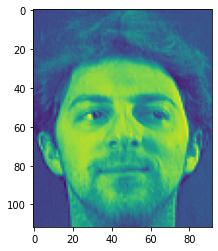

In [ ]:
from scipy import ndimage, misc
import cv2
test1 = read_image('arub/s' + str(7) + '/' + str(7) + '.pgm', 'rw+')
#REAL=read_image('arub/arham'+'.pgm','rw+')
test2 = read_image('arub/s' + str(1) + '/' + str(2) + '.pgm', 'rw+')
test3 = read_image('arub/s' + str(36) + '/' + str(9) + '.pgm', 'rw+')
#imww= cv2.resize(REAL,(92,112))
#plt.imshow(imww,cmap="gray")
#plt.show();
plt.imshow(test1, cmap="gray")
plt.show() 
plt.imshow(test2, cmap="gray") 
plt.show()
plt.imshow(test3, cmap="gray") 
plt.show()
def demo(test1,test2,loaded_model):
  imgtest1 = test1
  imgtest2 = test2
  dim1=imgtest1.shape[0]
  dim2=imgtest2.shape[1]
  finalTest1 = np.zeros([1, 2, 1, dim1, dim2])
  
  finalTest1[0, 0, 0, :, :] = imgtest1
  finalTest1[0, 1, 0, :, :] = imgtest2
  print(finalTest1[:,0])
  plt.imshow(imgtest1)
  p=model.predict([finalTest1[:,0],finalTest1[:,1]])
  print(p[0][0])
  
  if(p[0][0]<4):
    return "Matched"
  else:
    return "Not Matched"

demo(test1,test3,model)

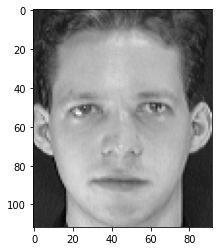

In [ ]:

 
 

plt.imshow(image1, cmap="gray") 
plt.show() 